In [9]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import torch
import numpy as np
from tqdm import tqdm, trange
# # install open assistant model_training module (e.g. run `pip install -e .` in `model/` directory of open-assistant repository)
# import model_training.models.reward_model

# We instead make a copy of the reward model code here, so that we can import it
import reward_model
from train_router import RouterDataset
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

In [39]:
eval_dataset = torch.load("router/eval_dataset.pt")
eval_indices = eval_dataset.indices
router_dataset = torch.load("router_dataset.pt")

def test_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
    )
    model.eval()
    model.cuda()

    predictions = []

    for index in tqdm(eval_indices):
        example = router_dataset[index]

        inputs = tokenizer(
            example["input"],
            return_tensors="pt",
        )

        inputs = {k: v.cuda() for k, v in inputs.items()}
        with torch.inference_mode():
            output = model(**inputs)

        score = output.logits[0, 0].item()
        example["score"] = score
        predictions.append(example)

    print("=== Score Analysis ===")

    all_scores = [p["score"] for p in predictions]
    all_scores = np.array(all_scores)
    print("Mean score:", all_scores.mean())
    print("Std score:", all_scores.std())
    print("Min score:", all_scores.min())
    print("Max score:", all_scores.max())

    threshold_list = np.arange(all_scores.min(), all_scores.max(), 0.2)
    score_list = []
    percentage_list = []

    print("=== Threshold Analysis ===")

    for threshold in threshold_list:
        total_score = 0
        total_count = 0
        for example in predictions:
            if example["score"] >= threshold:
                total_score += example["preference"] - 0.5 # example["score_4"]
                total_count += 1
            else:
                total_score += 0.5 -example["preference"] # example["score_35"]
        print(f"Threshold: {threshold:.2f}, Score: {total_score / len(predictions):.2f}, Percentage: {total_count / len(predictions):.2f}")
        score_list.append(total_score / len(predictions))
        percentage_list.append(total_count / len(predictions))

    random_score_list = []
    random_score_function = lambda x: score_list[0] * x + score_list[-1] * (1 - x)
    for percentage in percentage_list:
        random_score_list.append(random_score_function(percentage))

    plt.figure(figsize=(8, 24))

    plt.subplot(3, 1, 1)
    plt.plot(percentage_list, score_list, label="Router")
    plt.plot(percentage_list, random_score_list, label="Random")
    plt.xlabel("Percentage")
    plt.ylabel("Score")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(threshold_list, percentage_list)
    plt.xlabel("Threshold")
    plt.ylabel("Percentage")

    plt.subplot(3, 1, 3)
    plt.plot(threshold_list, score_list)
    plt.xlabel("Threshold")
    plt.ylabel("Score")


    plt.show()

    return percentage_list, score_list, random_score_list, threshold_list

In [40]:
model0 = "tianlecai/smart_router"

100%|██████████| 5201/5201 [03:37<00:00, 23.94it/s]


=== Score Analysis ===
Mean score: 1.2363747880564724
Std score: 0.5972754671663006
Min score: -0.09765625
Max score: 2.6875
=== Threshold Analysis ===
Threshold: -0.10, Score: 0.14, Percentage: 1.00
Threshold: 0.10, Score: 0.14, Percentage: 0.96
Threshold: 0.30, Score: 0.13, Percentage: 0.91
Threshold: 0.50, Score: 0.13, Percentage: 0.86
Threshold: 0.70, Score: 0.12, Percentage: 0.78
Threshold: 0.90, Score: 0.10, Percentage: 0.70
Threshold: 1.10, Score: 0.08, Percentage: 0.61
Threshold: 1.30, Score: 0.05, Percentage: 0.50
Threshold: 1.50, Score: 0.02, Percentage: 0.38
Threshold: 1.70, Score: -0.03, Percentage: 0.25
Threshold: 1.90, Score: -0.07, Percentage: 0.14
Threshold: 2.10, Score: -0.11, Percentage: 0.05
Threshold: 2.30, Score: -0.13, Percentage: 0.01
Threshold: 2.50, Score: -0.14, Percentage: 0.00


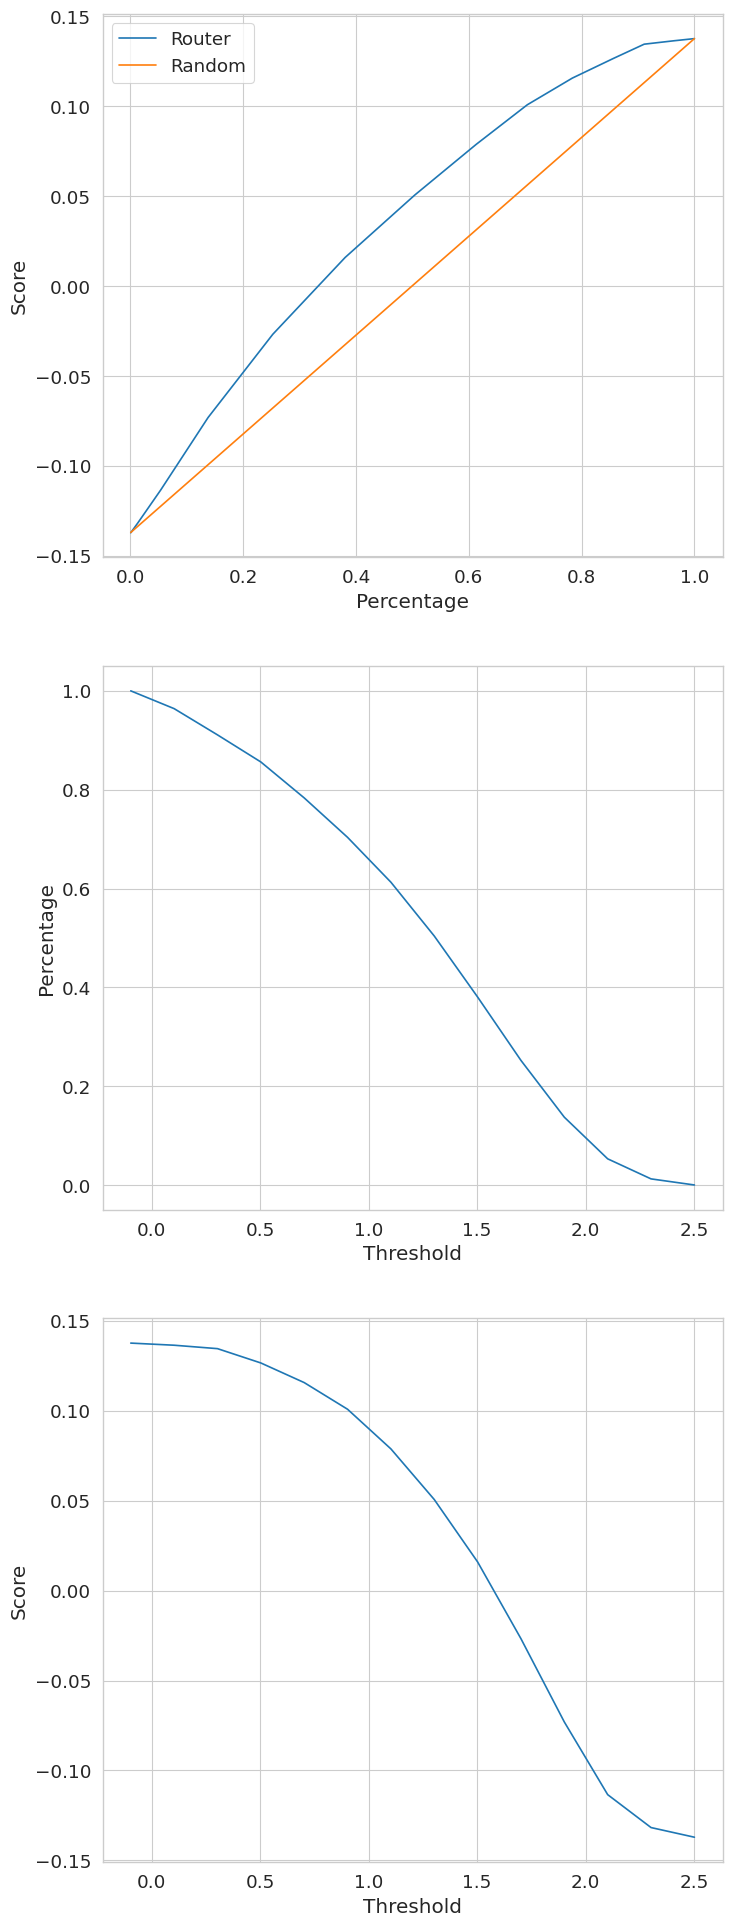

In [41]:
percentage_list0, score_list0, random_score_list0, threshold_list0 = test_model(model0)

In [24]:
percentage_convert = lambda x: x * 4 + (1 - x) * 3.5

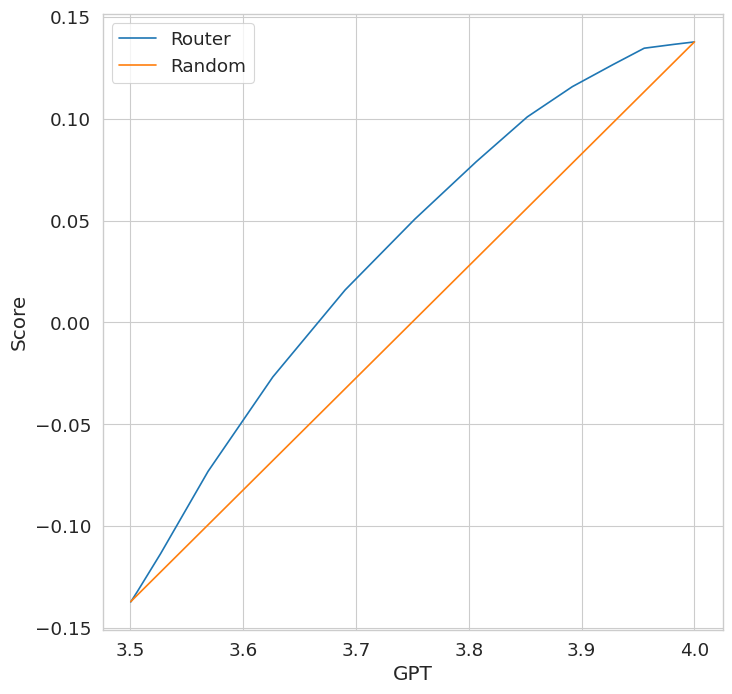

In [45]:
plt.figure(figsize=(8, 8))
plt.plot(list(map(percentage_convert, percentage_list0)), score_list0, label="Router")
# plt.plot(percentage_list1, score_list1, label="pythia_1.4b")
# plt.plot(percentage_list2, score_list2, label="deberta_base")
plt.plot(list(map(percentage_convert, percentage_list0)), random_score_list0, label="Random")
plt.xlabel("GPT")
plt.ylabel("Score")

plt.legend()
plt.show()